In [32]:
# Imports
import numpy as np
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
from sklearn.ensemble import RandomForestRegressor #Regression Baseline Model
from sklearn.metrics import mean_squared_error 
import time
import seaborn as sb
import csv
import pandas as pd
import os

In [33]:
def dataset_create(path, test1 = False):
    headers = ['X_FP','X_ACC_IMU', 'X_ANG_IMU', 'Y_FP', 'Y_ACC_IMU', 'Y_ANG_IMU',
                    'ROLL', 'YAW', 'ACC_X', 'ACC_Y', 'ROLL_VEL', 'YAW_VEL']
    x_headers = ['X_FP','X_ACC_IMU', 'X_ANG_IMU','ROLL', 'ACC_X', 'ROLL_VEL']
    y_headers = ['Y_FP', 'Y_ACC_IMU', 'Y_ANG_IMU', 'YAW', 'ACC_Y', 'YAW_VEL']

    if test1 == False:
        file_name_list = os.listdir(path)
        ext= ".DS_Store", ".pth"
        filtered_file_name_list = []

        for file in file_name_list:
            if not file.endswith(ext):
                filtered_file_name_list.append(file)
        
        dfs = [pd.read_csv(path + file, names=headers,) for file in filtered_file_name_list]
        

        data_frame = dfs.pop(0)
        
       
        for df in dfs:
            data_frame = data_frame.merge(df,on = headers, how = 'outer')
    else:
        data_frame = pd.read_csv(path, names=headers)

    df_x = data_frame[x_headers]
    df_y = data_frame[y_headers]
    

    dataset_x = np.array(df_x.astype(np.float32))
    dataset_y = np.array(df_y.astype(np.float32))

    return dataset_x, dataset_y

In [34]:
path_train =  r"/Users/reimyousef/Desktop/S24/COP-Estimation/dataset/train/"
path_val = r"/Users/reimyousef/Desktop/S24/COP-Estimation/dataset/val/"

[train_set_x, train_set_y] = dataset_create(path_train)
[val_set_x, val_set_y] = dataset_create(path_val)

In [35]:
def save_np_csv(x, filename):
    df = pd.DataFrame(x)
    df.to_csv(filename, index=False)

In [36]:
#save_np_csv(train_set_x,r"C:\Users\steph\source\COP Estimation\train_set_x.csv")
#save_np_csv(train_set_y,r"C:\Users\steph\source\COP Estimation\train_set_y.csv")
#save_np_csv(val_set_x,r"C:\Users\steph\source\COP Estimation\val_set_x.csv")
#save_np_csv(val_set_y,r"C:\Users\steph\source\COP Estimation\val_set_y.csv")

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [38]:
# Data Loader
def get_data_loader(train_set, val_set, test_set,batch_size):
  train_set = torch.from_numpy(train_set)
  val_set = torch.from_numpy(val_set)
  relevant_train_indices = list(range(0,len(train_set)))
  relevant_val_indices = list(range(0,len(val_set)))
  np.random.seed(50)
  np.random.shuffle(relevant_train_indices)
  np.random.shuffle(relevant_val_indices)

  # split into training and validation indices
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              num_workers=1, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                            num_workers=1, sampler=val_sampler)

# **** NOTE: DataLoader with pin_memory=True may speed up GPU

  if test_set == True:
    test_set = torch.from_numpy(test_set)
    relevant_test_indices = list(range(0,len(test_set)))
    np.random.shuffle(relevant_test_indices)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            num_workers=1, sampler=test_sampler)
  else:
    test_loader = []
  
  return train_loader, val_loader, test_loader

In [39]:
def get_model_name(name, batch_size, learning_rate, epoch, x):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_{4}.pth".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch, x) 
    return path

In [40]:
def NormalizeData(data):
    #grad = data.grad()
    data = data.detach().numpy()
    out = (data - np.min(data)) / (np.max(data) - np.min(data))
    out = torch.tensor(out, requires_grad=True)
    #print(out)
    return out

In [41]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        #print("pred:")
        #print(pred)
        #print("pred norm:")
        #print(NormalizeData(pred))
        return torch.sqrt(self.mse(torch.log(NormalizeData(pred) + 1), torch.log(NormalizeData(actual) + 1)))

In [42]:
# Regression Evaluation Function
def evaluate_regression(model, loader, criterion):
      
    total_loss = 0.0
    #total_err = 0.0
    #total_epoch = 0
    #correct = 0
    total = 0
    #error = 0
    MSE_total = 0
    for i, data in enumerate(loader):
        stats_set = []
        labels_set = []
        for stats in data:
          label = float(stats[0]) # First index in stats is label
          labels_set.append(label)
          stats_sub = []
          for j in stats[1:]:
            stats_sub.append(j)
          stats_set.append(stats_sub)
        labels_set = torch.FloatTensor(labels_set)
        labels_set = labels_set.unsqueeze(1)
        stats_set = torch.FloatTensor(stats_set)
        
        #if torch.cuda.is_available():
         #   labels_set = labels_set.cuda()
         #   stats_set = stats_set.cuda()

        outputs = model(stats_set)
        loss = criterion(outputs, labels_set) #float
        #print(loss)
        MSE = mean_squared_error(outputs.detach().numpy(), labels_set.long().detach().numpy())
        #corr = (outputs > 0.0).squeeze().long()
        #total_err += int(corr.sum())
        total_loss += loss.item()
        MSE_total += MSE
        #total_epoch += len(labels_set)
        #pred = outputs.max(1, keepdim=True)[1]
        #correct += pred.eq(labels_set.view_as(pred)).sum().item()
        total += stats_set.shape[0]
    #error = float(total_err) / total_epoch
    #acc = correct / total
    loss = float(total_loss) / (i + 1)
    MSE_total = MSE_total/total
    return loss , MSE_total

In [43]:
# Regression Training Function
def train_net_regression(model, train_loader, val_loader, batch_size=64, learning_rate=0.0001, num_epochs=50, x=True):
    x = "x"
    if x == False:
       x = "y"
    torch.manual_seed(50)

    #criterion = RMSLELoss()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs, train_losses, val_losses, train_mses, val_mses = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            stats_set = []
            labels_set = []
            for stats in data:
              label = float(stats[0]) # First index in stats is label
              labels_set.append(label)
              stats_sub = []
              for j in stats[1:]:
                stats_sub.append(j)
              stats_set.append(stats_sub)
            labels_set = torch.FloatTensor(labels_set)
            labels_set = labels_set.unsqueeze(1)
            stats_set = torch.FloatTensor(stats_set)
            
            #if torch.cuda.is_available():
               #labels_set = labels_set.cuda()
               #stats_set = stats_set.cuda()

            out = model(stats_set)
            loss = criterion(out, labels_set) #float
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            model_path = get_model_name(model.name, batch_size, learning_rate, epoch, x)
            model_path = f"/Users/reimyousef/Desktop/S24/COP-Estimation/dataset/train/{model_path}"
            torch.save(model.state_dict(), model_path)

        train_loss, train_MSE= evaluate_regression(model, train_loader, criterion)
        val_loss, val_MSE = evaluate_regression(model, val_loader, criterion)
        print(("Epoch {}: Train loss: {}, Train MSE: {}|"+
               "Validation loss: {}, Validation MSE: {}").format(
                   epoch + 1,
                   train_loss,
                   train_MSE,
                   val_loss,
                   val_MSE))
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mses.append(train_MSE)
        val_mses.append(val_MSE)
        epochs.append(epoch)

    #Mean-Square Error (MSE)
    plt.title("Accuracy vs. Validation Mean-Square Error (MSE)")
    plt.plot(epochs, train_mses, label="Train")
    plt.plot(epochs, val_mses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    #plt.ylim(0,25)
    plt.legend(loc='best')
    plt.show()

    #Loss
    plt.title("Accuracy vs. Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    #plt.ylim(0,5)
    plt.legend(loc='best')
    plt.show()

In [44]:
class ANN_regression(nn.Module):
    def __init__(self):
        self.name = "ANN"
        super(ANN_regression, self).__init__()
        self.layer1 = nn.Linear(5, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 16)
        self.layer5 = nn.Linear(16,1)
    def forward(self, x):
        activation1 = self.layer1(x)
        activation1 = F.relu(activation1)
        activation2 = self.layer3(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer4(activation2)
        activation4 = self.layer5(activation3)
        return activation4

In [45]:
batch_size = 64
train_loader_x, val_loader_x, test_loader_x = get_data_loader(train_set_x, val_set_x, False, batch_size)
train_loader_y, val_loader_y, test_loader_y = get_data_loader(train_set_y, val_set_y, False, batch_size)

Epoch 1: Train loss: 128.0745037854728, Train MSE: 1.9391315207846775|Validation loss: 114.48059711511907, Validation MSE: 1.7352307302991954
Epoch 2: Train loss: 118.51528386908062, Train MSE: 1.8398055381024012|Validation loss: 102.79693502309371, Validation MSE: 1.6091726877273889
Epoch 3: Train loss: 120.87059987601587, Train MSE: 1.8302195681451798|Validation loss: 106.12781172104549, Validation MSE: 1.6077817993801764
Epoch 4: Train loss: 124.94628669286179, Train MSE: 1.9330687549333878|Validation loss: 120.85393926770625, Validation MSE: 1.8789306606189806
Epoch 5: Train loss: 122.17245841592045, Train MSE: 1.8941266308680318|Validation loss: 105.07126644679478, Validation MSE: 1.6398938658308215
Epoch 6: Train loss: 118.15697157261735, Train MSE: 1.7992194457848982|Validation loss: 107.42532751233516, Validation MSE: 1.6347542978981278
Epoch 7: Train loss: 113.2386676271083, Train MSE: 1.7339683647200677|Validation loss: 88.84159405099408, Validation MSE: 1.3644833873624047
Ep

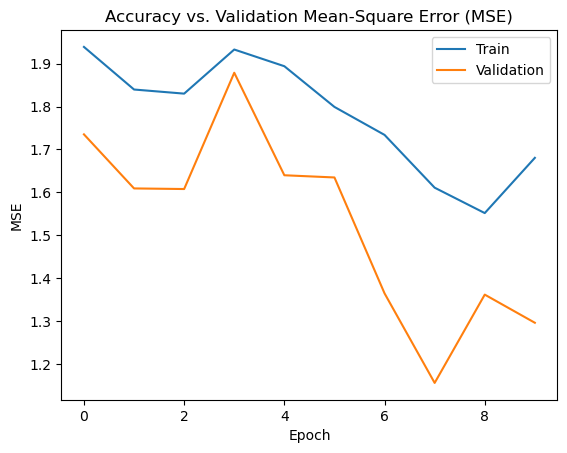

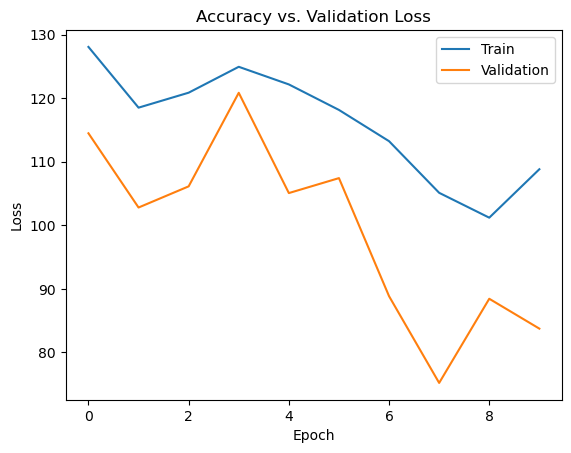

In [46]:
net_reg_x = ANN_regression()
#model_path = f"C:\\Users\Stephanie\source\repos\COP\COP-Estimation\ANN_test3_x.pth"
#net_reg_x.load_state_dict(torch.load(model_path))
train_net_regression(net_reg_x,train_loader_x,val_loader_x,batch_size, learning_rate = 0.005, num_epochs = 10, x="x")

Epoch 1: Train loss: 313.6886176157806, Train MSE: 4.726604287535667|Validation loss: 305.1559215579019, Validation MSE: 4.595909819197393
Epoch 2: Train loss: 310.75875906216896, Train MSE: 4.680064452310528|Validation loss: 310.3098943504578, Validation MSE: 4.671792950918851
Epoch 3: Train loss: 299.1114526263738, Train MSE: 4.513174710323963|Validation loss: 288.9437175561666, Validation MSE: 4.358328950948132
Epoch 4: Train loss: 295.093247339281, Train MSE: 4.448803922870659|Validation loss: 289.1520793458811, Validation MSE: 4.35785635502304
Epoch 5: Train loss: 293.41429405858963, Train MSE: 4.422849077914318|Validation loss: 285.27995598350947, Validation MSE: 4.297713306749846
Epoch 6: Train loss: 297.04994160280387, Train MSE: 4.476816123026158|Validation loss: 285.6599789277458, Validation MSE: 4.299473677150026
Epoch 7: Train loss: 297.8296646829379, Train MSE: 4.487560978643368|Validation loss: 297.7513770056188, Validation MSE: 4.488066913368838
Epoch 8: Train loss: 294.

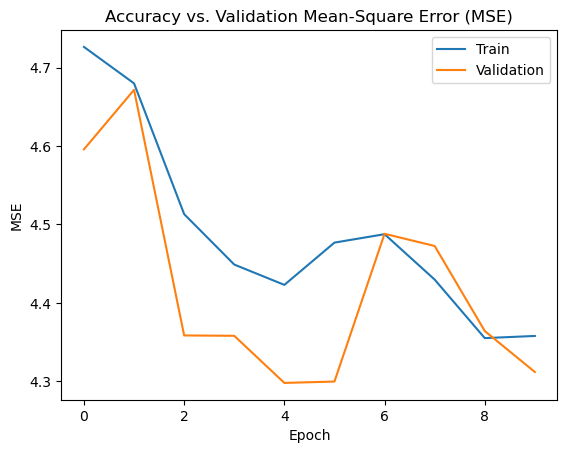

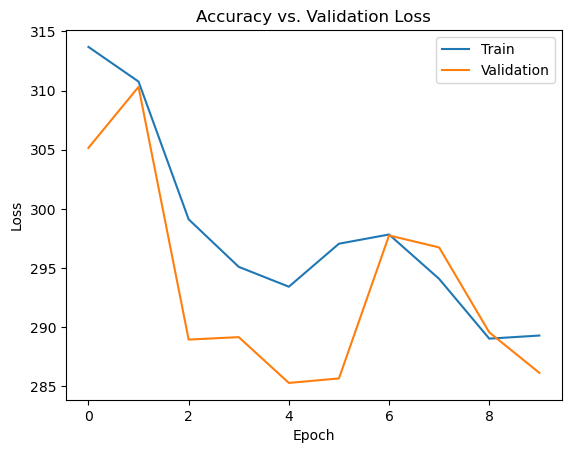

In [47]:
net_reg_y = ANN_regression()
#model_path = f"C:\\Users\steph\source\COP Estimation\ANN_test1.pth"
#net_reg_x.load_state_dict(torch.load(model_path))
train_net_regression(net_reg_y,train_loader_y,val_loader_y,batch_size, learning_rate = 0.005, num_epochs = 10, x="y")

In [48]:
model_path = r"/Users/reimyousef/Desktop/S24/COP-Estimation/ANN_test1_x.pth"
torch.save(net_reg_y.state_dict(), model_path)

In [49]:
model_path = r"/Users/reimyousef/Desktop/S24/COP-Estimation/ANN_test1_y.pth"
torch.save(net_reg_y.state_dict(), model_path)

In [50]:
evaluate_regression(net_reg_x, val_loader_x, nn.MSELoss())

(83.75364287462595, 1.2962428896595868)

In [51]:
# Random Forest Baseline Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def regression_baseline_model(num_iterations, train_set):
  best_MSE = 0
  best_iter = 0
  total_MSE = 0
  for iters in range(1,num_iterations+1):
    regression_model = RandomForestRegressor()
    stats = train_set[:,1:]
    actual_position = train_set[:,0]

    regression_model.fit(stats,actual_position)
    position_prediction = regression_model.predict(stats)
    MSE = mean_squared_error(position_prediction, actual_position)

    if (best_MSE == 0):
      best_MSE = MSE
      best_iter = iter
      best_model = regression_model
    elif (MSE<best_MSE):
      best_MSE = MSE
      best_iter = iters
      best_model = regression_model
    
    total_MSE += MSE

    print(("Iteration {}: Train MSE {} ").format(
                   iters,
                   MSE))
  
  print ("The best MSE is", best_MSE, "which occurred at iteration", best_iter)
  print ("The average MSE is", total_MSE/num_iterations)

  return best_model

In [52]:
rf_regression_x = regression_baseline_model(1, train_set_x)

Iteration 1: Train MSE 10.520907484416947 
The best MSE is 10.520907484416947 which occurred at iteration <built-in function iter>
The average MSE is 10.520907484416947


In [53]:
rf_regression_y = regression_baseline_model(1, train_set_y)

Iteration 1: Train MSE 30.782798447904007 
The best MSE is 30.782798447904007 which occurred at iteration <built-in function iter>
The average MSE is 30.782798447904007


In [54]:
# SVM Model

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def svm_model(train_set, val_set):
    stats_train = train_set[:,1:]
    actual_position_train = train_set[:,0]

    sc_stats = StandardScaler()
    sc_pos = StandardScaler()
    stats_train = sc_stats.fit_transform(stats_train)
    actual_position_train = sc_pos.fit_transform(actual_position_train.reshape(len(actual_position_train),1))[:,0]
    regressor = SVR(kernel = 'rbf')
    regressor.fit(stats_train, actual_position_train)

    stats_val = val_set[:,1:]
    actual_position_val = val_set[:,0]

    position_prediction_train = regressor.predict(stats_train)
    position_prediction_val = regressor.predict(stats_val)

    position_prediction_train = sc_pos.inverse_transform(
                                position_prediction_train.reshape(len(position_prediction_train),1))[:,0]
    position_prediction_val = sc_pos.inverse_transform(
                                position_prediction_val.reshape(len(position_prediction_val),1))[:,0]

    mse_train = mean_squared_error(position_prediction_train, actual_position_train)
    mse_val = mean_squared_error(position_prediction_val, actual_position_val)

    print(("Training MSE {}: Validation MSE {} ").format(
                   mse_train,
                   mse_val))
    
    return regressor, sc_pos

In [55]:
svm_regressor_x, x_scale = svm_model(train_set_x, val_set_x)
svm_regressor_y, y_scale = svm_model(train_set_y, val_set_y)

Training MSE 1066.3188548753253: Validation MSE 1358.8531100452144 
Training MSE 81.57341817973735: Validation MSE 372.01014851232475 


In [56]:
# Plot Predicted COP

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

def plt_pred_COP(path, model_x, model_y, x_scale=0, y_scale=0, ANN=False, svr=False):
    [test_set_x, test_set_y] = dataset_create(path, test1=True)
    
    stats_x = test_set_x[:,1:]
    pos_x = test_set_x[:,0]

    stats_y = test_set_y[:,1:]
    pos_y = test_set_y[:,0]

    if svr == True:
        position_prediction_x = model_x.predict(stats_x)
        position_prediction_y = model_y.predict(stats_y)

        position_prediction_x = x_scale.inverse_transform(
                                position_prediction_x.reshape(len(position_prediction_x),1))[:,0]
        position_prediction_y = y_scale.inverse_transform(
                                position_prediction_y.reshape(len(position_prediction_y),1))[:,0]
    elif ANN == True:
        position_prediction_x = model_x(torch.tensor(stats_x)).detach().numpy()
        position_prediction_y = model_y(torch.tensor(stats_y)).detach().numpy()
        
        position_prediction_x = position_prediction_x.reshape(len(position_prediction_x),)
        position_prediction_y = position_prediction_y.reshape(len(position_prediction_y),)
    else:
        position_prediction_x = model_x.predict(stats_x)
        position_prediction_y = model_y.predict(stats_y)
        
    time_vector = np.array(range(0,len(pos_x))) / 90

    
    plt.figure(figsize=(5,3))
    plt.title("COP ML")
    plt.plot(time_vector, pos_x * 1000, label="Force Plate", color='black')
    plt.plot(time_vector, position_prediction_x * 1000, label="IMU", color='#FF66B3')
    plt.xlabel("Time (s)")
    plt.ylabel("Position (mm)")
    #plt.ylim(0,25)
    #plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(5,3))
    plt.title("COP AP")
    plt.plot(time_vector, pos_y * 1000, label="Force Plate", color='black')
    plt.plot(time_vector, position_prediction_y * 1000, label="IMU", color='#FF66B3')
    plt.xlabel("Time (s)")
    plt.ylabel("Position (mm)")
    #plt.ylim(0,5)
    #plt.legend(loc='best')
    plt.show()

    corr_x = pearsonr(position_prediction_x,pos_x)
    corr_y = pearsonr(position_prediction_y,pos_y)

    rms_x = mean_squared_error(pos_x, position_prediction_x, squared=False)
    rms_y = mean_squared_error(pos_y, position_prediction_y, squared=False)

    norm_rmse_x = rms_x/(max(pos_x) - min(pos_x))
    norm_rmse_y = rms_x/(max(pos_y) - min(pos_y))

    print(("Pearson Correlation ML {}: Pearson Correlation AP {} ").format(
                   corr_x[0],corr_y[0]))
    
    print(("RMSE ML {}: RMSE AP {} ").format(
                   rms_x,rms_y))
    
    print(("Normalized RMSE ML {}: Normalized RMSE AP {} ").format(
                   norm_rmse_x,norm_rmse_y))

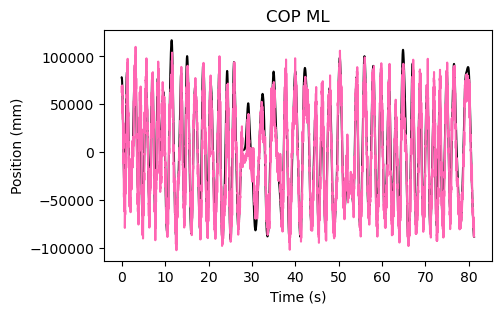

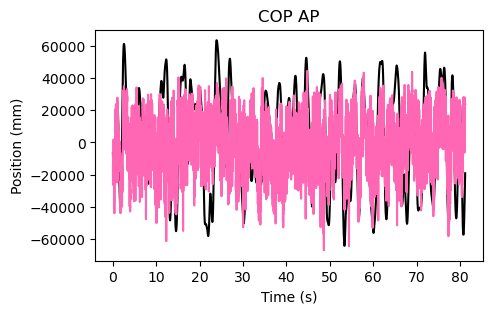

Pearson Correlation ML 0.9552838514912358: Pearson Correlation AP 0.24239005780612813 
RMSE ML 16.926884688400467: RMSE AP 31.212423429294176 
Normalized RMSE ML 0.08090601369732128: Normalized RMSE AP 0.1329665421336098 


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
test_path = r"/Users/reimyousef/Desktop/S24/COP-Estimation/dataset/val/2024-06-20_standing_dynamic_03.csv"
#random forest model
plt_pred_COP(test_path, rf_regression_x, rf_regression_y)

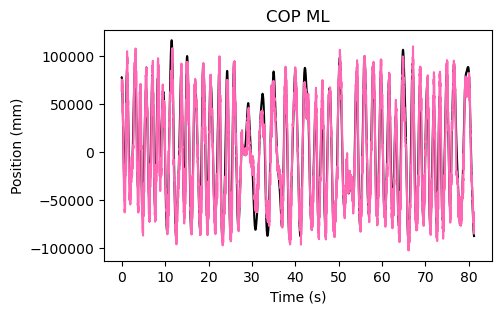

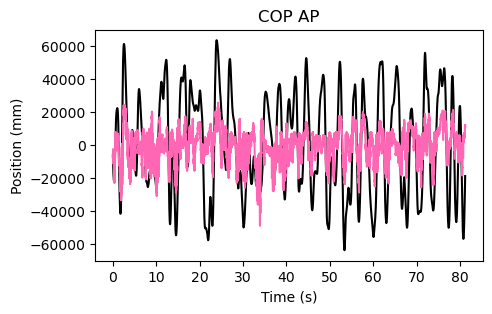

Pearson Correlation ML 0.963656799711756: Pearson Correlation AP 0.4501110624906808 
RMSE ML 14.853312492370605: RMSE AP 27.48717498779297 
Normalized RMSE ML 0.07099489122629166: Normalized RMSE AP 0.1166779175400734 


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
#model_path = f"C:\\Users\steph\source\COP Estimation\ANN_test4_y.pth"
#net_reg_y.load_state_dict(torch.load(model_path))

test_path = r"/Users/reimyousef/Desktop/S24/COP-Estimation/dataset/val/2024-06-20_standing_dynamic_03.csv"
plt_pred_COP(test_path, net_reg_x, net_reg_y, ANN=True)